In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


#Preprocessing

1.   Remove punctuation/special characters
2.   Convert all string to lower case

In [ ]:
df = pd.read_csv('train.csv',header=None)

In [ ]:
df.columns = ['Phrase','Sentiment']

In [ ]:
df.head(3)

,Phrase,Sentiment
0,Dr M now interim PM as Agong accepts his resig...,0
1,MMAG's M Jets targets annual cargo volume to g...,1
2,Civil servants will continue to provide qualit...,0


In [ ]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

def clean_str(x):
    x = str(x)

    x = x.lower()

    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)

    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')

    for punct in strip_chars:
        x = x.replace(punct, ' ')

    for punct in puncts:
        x = x.replace(punct, f' {punct} ')

    x = x.replace(" '", " ")
    x = x.replace("' ", " ")

    return x

In [ ]:
#Now we have 3 columns [Phrase(Original text), Sentiment,text(Cleaned text)]
df['text'] = df['Phrase'].apply(clean_str)

It's important to have a balanced training set for our classifier, here's a simplistic way to approach this

In [ ]:
df_0 = df[df['Sentiment'] == -1].sample(frac=1)
df_1 = df[df['Sentiment'] == 0].sample(frac=1)
df_2 = df[df['Sentiment'] == 1].sample(frac=1)

In [ ]:
# Find out the size of all example sets
print(len(df_0))
print(len(df_1))
print(len(df_2))

13037
24033
24622


In [ ]:
# We want a balanced set for training
# so we take the minimum size among all as standard
sample_size = min(len(df_0), len(df_1), len(df_2))

In [ ]:
# Chop all sets to the sample size
data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_2.head(sample_size)]).sample(frac=1)

In [ ]:
data.head(3)

,Phrase,Sentiment,text
18763,china everbright water wins shandong water pla...,1,china everbright water wins shandong water pla...
56328,irb appeals dismissal of rm26m tax bill agains...,1,irb appeals dismissal of rm26m tax bill agains...
16241,hong leong finance 1q earnings up 13.2% to s$1...,1,hong leong finance 1q earnings up 13 2 % to s...


In [ ]:
# insert new column to record the length of all original sentence text
# we might need to handle some outliers if the sentence is too long

data['l'] = data['Phrase'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 9.767993659072895
max length of sentence: 89
std dev length of sentence: 2.8531642998019384


In [ ]:
# these sentences aren't that long so we may as well use the whole string
sequence_length = 89

#Text tokenization
*oov_token* : out-of-vocabulary
<br>
When a new text contains words not in the corpus vocabulary, these words will be
label as oov_token. Else, Keras will ignore the word. <br>
To not miss any word, we initialize the Tokenizer with the oov_token parameter.

In [ ]:
max_features = 20000

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(data['Phrase'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(data['Phrase'].values)

*pad_sequences* is used to ensure that all sequences in a list have the same length. <br> By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

*pd. get_dummies* will produce one-hot encoding (representation of categorical variables as binary vectors).

In [ ]:
# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(data['Sentiment']).values


In [ ]:
data['Sentiment'].value_counts()

-1    13037
 1    13037
 0    13037
Name: Sentiment, dtype: int64

In [ ]:
# lets keep a couple of thousand samples back as a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 3912


Now we need to get the word GloVe embeddings into a format ready to query later.


In [ ]:
import os
embeddings_index = {}
f = open('glove.6B.100d.txt')

In [ ]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


 *word_index*: A dictionary of words and their uniquely assigned integers.

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32694 unique tokens.


Go through all the words in our tokenizer and find the word embedding (vector) for each. <BR>
For words we can't find, we give each it's own unique random vector, which we can make trainable later.

In [ ]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# GloVe dimension 100D
embedding_dim = 100

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

20001


*embedding matrix* : the set of vectors representing our words

In [ ]:
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

#Build model

*CuDNNLSTM*: Fast LSTM implementation backed by CuDNN. Can only be run on GPU.

In [ ]:
model = Sequential()

# Add embedding layer
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))

# Add dropout layer to reduce overfitting
model.add(SpatialDropout1D(0.2))

# add bidirectional layer
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dropout(0.25))

# add 3D dense layer
# feeds all outputs from the previous layer to all its neurons
model.add(Dense(units=3, activation='softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 89, 100)           2000100   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 89, 100)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 89, 128)          84992     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41472     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
# Input validation set & clean it
df_validation = pd.read_csv('validation.csv', header=None)
df_validation.columns = ['Phrase','Sentiment']
df_validation['text'] = df_validation['Phrase'].apply(clean_str)
x = tokenizer.texts_to_sequences(df_validation['text'].values)
x = pad_sequences(x, sequence_length)
y = pd.get_dummies(df_validation['Sentiment']).values

In [ ]:
df_validation['Sentiment'].value_counts()

In [ ]:
X_valid, Y_valid = x, y

In [ ]:
# Train model (use validation data as validation set)
batch_size = 128
history = model.fit(X_train, y_train, epochs=5, batch_size= batch_size, verbose=1, validation_data=(X_valid, Y_valid))


Epoch 1/5
275/275 [==============================] - 6s 21ms/step - loss: 0.5600 - accuracy: 0.7796 - val_loss: 0.9559 - val_accuracy: 0.5790
Epoch 2/5
275/275 [==============================] - 6s 20ms/step - loss: 0.5223 - accuracy: 0.7964 - val_loss: 1.0461 - val_accuracy: 0.5600
Epoch 3/5
275/275 [==============================] - 6s 20ms/step - loss: 0.4835 - accuracy: 0.8123 - val_loss: 1.1224 - val_accuracy: 0.5670
Epoch 4/5
275/275 [==============================] - 6s 20ms/step - loss: 0.4431 - accuracy: 0.8304 - val_loss: 1.0486 - val_accuracy: 0.5580
Epoch 5/5
275/275 [==============================] - 6s 20ms/step - loss: 0.4104 - accuracy: 0.8440 - val_loss: 1.0878 - val_accuracy: 0.5700


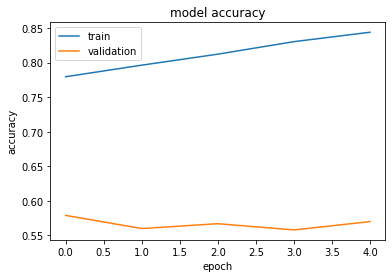

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

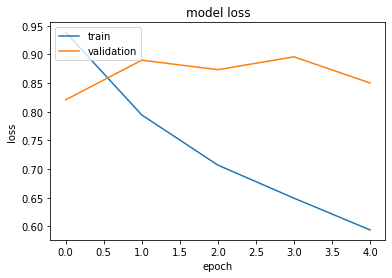

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Check how does this model perform?

In [ ]:
y_hat = model.predict(X_test)

In [ ]:
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

In [ ]:
conf = confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))
conf

In [ ]:
plt.imshow(conf)

In [ ]:
# Input test set
df_test = pd.read_csv('test.csv', header = None)
df_test.columns = ['Phrase','Sentiment']
df_test['text'] = df_test['Phrase'].apply(clean_str)
x = tokenizer.texts_to_sequences(df_test['text'].values)
x = pad_sequences(x, sequence_length)

In [ ]:
y_hat = model.predict(x)

In [ ]:
df_test['Sentiment'].value_counts()

 1    439
 0    305
-1    256
Name: Sentiment, dtype: int64

In [ ]:
df_results = pd.DataFrame(list(zip(df_test['Phrase'].values,
                                   list(map(lambda x: np.argmax(x), y_hat)))),
                          columns=['Phrase', 'Sentiment'])

In [ ]:
df_results['Sentiment'].replace([2], [-1], inplace=True)

In [ ]:
df_results.to_csv('prediction_result.csv', index=False)

In [ ]:
df_results.head(5)

,Phrase,Sentiment
0,fgv explains accounting treatment of replantin...,1
1,rhb founder to take up stake in priceworth via...,1
2,time to buy 37% stake in thai telecoms operato...,1
3,malaysia ranks low in graft survey,2
4,' no cover-up ',1
